# Efficient Interpolation & Exploration with STONED SELFIES


### By: AkshatKumar Nigam, Robert Pollice, Mario Krenn, Gabriel dos Passos Gomes, and Alan Aspuru-Guzik

Paper Link: https://doi.org/10.26434/chemrxiv.13383266.v2 \
Paper Github: https://github.com/aspuru-guzik-group/stoned-selfies 

<img src="https://github.com/aspuru-guzik-group/stoned-selfies/blob/main/readme_docs/fig_main_algo.png?raw=True" width="900" />


# Experiment Imports / Functions: 

In [76]:
import time 
import selfies
import rdkit
import random
import numpy as np
import random
from rdkit import Chem
from selfies import encoder, decoder
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import Mol
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint, GetBTFingerprint
from rdkit.Chem.Pharm2D import Generate, Gobbi_Pharm2D
from rdkit.Chem import Draw

from rdkit.Chem import MolToSmiles as mol2smi
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

def randomize_smiles(mol):
    '''Returns a random (dearomatized) SMILES given an rdkit mol object of a molecule.
    Parameters:
    mol (rdkit.Chem.rdchem.Mol) :  RdKit mol object (None if invalid smile string smi)
    
    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object  (None if invalid smile string smi)
    '''
    if not mol:
        return None

    Chem.Kekulize(mol)
    return rdkit.Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=False,  kekuleSmiles=True) 


def sanitize_smiles(smi):
    '''Return a canonical smile representation of smi
    
    Parameters:
    smi (string) : smile string to be canonicalized 
    
    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object                          (None if invalid smile string smi)
    smi_canon (string)          : Canonicalized smile representation of smi (None if invalid smile string smi)
    conversion_successful (bool): True/False to indicate if conversion was  successful 
    '''
    try:
        mol = smi2mol(smi, sanitize=True)
        smi_canon = mol2smi(mol, isomericSmiles=False, canonical=True)
        return (mol, smi_canon, True)
    except:
        return (None, None, False)
    

def get_selfie_chars(selfie):
    '''Obtain a list of all selfie characters in string selfie
    
    Parameters: 
    selfie (string) : A selfie string - representing a molecule 
    
    Example: 
    >>> get_selfie_chars('[C][=C][C][=C][C][=C][Ring1][Branch1_1]')
    ['[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[Branch1_1]']
    
    Returns:
    chars_selfie: list of selfie characters present in molecule selfie
    '''
    chars_selfie = [] # A list of all SELFIE sybols from string selfie
    while selfie != '':
        chars_selfie.append(selfie[selfie.find('['): selfie.find(']')+1])
        selfie = selfie[selfie.find(']')+1:]
    return chars_selfie


class _FingerprintCalculator:
    ''' Calculate the fingerprint for a molecule, given the fingerprint type
    Parameters: 
        mol (rdkit.Chem.rdchem.Mol) : RdKit mol object (None if invalid smile string smi)
        fp_type (string)            :Fingerprint type  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)  
    Returns:
        RDKit fingerprint object
    '''

    def get_fingerprint(self, mol: Mol, fp_type: str):
        method_name = 'get_' + fp_type
        method = getattr(self, method_name)
        if method is None:
            raise Exception(f'{fp_type} is not a supported fingerprint type.')
        return method(mol)

    def get_AP(self, mol: Mol):
        return AllChem.GetAtomPairFingerprint(mol, maxLength=10)

    def get_PHCO(self, mol: Mol):
        return Generate.Gen2DFingerprint(mol, Gobbi_Pharm2D.factory)

    def get_BPF(self, mol: Mol):
        return GetBPFingerprint(mol)

    def get_BTF(self, mol: Mol):
        return GetBTFingerprint(mol)

    def get_PATH(self, mol: Mol):
        return AllChem.RDKFingerprint(mol)

    def get_ECFP4(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 2)

    def get_ECFP6(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 3)

    def get_FCFP4(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 2, useFeatures=True)

    def get_FCFP6(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 3, useFeatures=True)


def get_fingerprint(mol: Mol, fp_type: str):
    ''' Fingerprint getter method. Fingerprint is returned after using object of 
        class '_FingerprintCalculator'
        
    Parameters: 
        mol (rdkit.Chem.rdchem.Mol) : RdKit mol object (None if invalid smile string smi)
        fp_type (string)            :Fingerprint type  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)  
    Returns:
        RDKit fingerprint object
        
    '''
    return _FingerprintCalculator().get_fingerprint(mol=mol, fp_type=fp_type)

def mutate_selfie(selfie, max_molecules_len, write_fail_cases=False):
    '''Return a mutated selfie string (only one mutation on slefie is performed)
    
    Mutations are done until a valid molecule is obtained 
    Rules of mutation: With a 33.3% propbabily, either: 
        1. Add a random SELFIE character in the string
        2. Replace a random SELFIE character with another
        3. Delete a random character
    
    Parameters:
    selfie            (string)  : SELFIE string to be mutated 
    max_molecules_len (int)     : Mutations of SELFIE string are allowed up to this length
    write_fail_cases  (bool)    : If true, failed mutations are recorded in "selfie_failure_cases.txt"
    
    Returns:
    selfie_mutated    (string)  : Mutated SELFIE string
    smiles_canon      (string)  : canonical smile of mutated SELFIE string
    '''
    valid=False
    fail_counter = 0
    chars_selfie = get_selfie_chars(selfie)
    
    while not valid:
        fail_counter += 1
                
        alphabet = list(selfies.get_semantic_robust_alphabet()) # 34 SELFIE characters 

        choice_ls = [1, 2, 3] # 1=Insert; 2=Replace; 3=Delete
        random_choice = np.random.choice(choice_ls, 1)[0]
        
        # Insert a character in a Random Location
        if random_choice == 1: 
            random_index = np.random.randint(len(chars_selfie)+1)
            random_character = np.random.choice(alphabet, size=1)[0]
            
            selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index:]

        # Replace a random character 
        elif random_choice == 2:                         
            random_index = np.random.randint(len(chars_selfie))
            random_character = np.random.choice(alphabet, size=1)[0]
            if random_index == 0:
                selfie_mutated_chars = [random_character] + chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index+1:]
                
        # Delete a random character
        elif random_choice == 3: 
            random_index = np.random.randint(len(chars_selfie))
            if random_index == 0:
                selfie_mutated_chars = chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + chars_selfie[random_index+1:]
                
        else: 
            raise Exception('Invalid Operation trying to be performed')

        selfie_mutated = "".join(x for x in selfie_mutated_chars)
        sf = "".join(x for x in chars_selfie)
        
        try:
            smiles = decoder(selfie_mutated)
            mol, smiles_canon, done = sanitize_smiles(smiles)
            if len(selfie_mutated_chars) > max_molecules_len or smiles_canon=="":
                done = False
            if done:
                valid = True
            else:
                valid = False
        except:
            valid=False
            if fail_counter > 1 and write_fail_cases == True:
                f = open("selfie_failure_cases.txt", "a+")
                f.write('Tried to mutate SELFIE: '+str(sf)+' To Obtain: '+str(selfie_mutated) + '\n')
                f.close()
    
    return (selfie_mutated, smiles_canon)

def get_mutated_SELFIES(selfies_ls, num_mutations): 
    ''' Mutate all the SELFIES in 'selfies_ls' 'num_mutations' number of times. 
    
    Parameters:
    selfies_ls   (list)  : A list of SELFIES 
    num_mutations (int)  : number of mutations to perform on each SELFIES within 'selfies_ls'
    
    Returns:
    selfies_ls   (list)  : A list of mutated SELFIES
    
    '''
    for _ in range(num_mutations): 
        selfie_ls_mut_ls = []
        for str_ in selfies_ls: 
            
            str_chars = get_selfie_chars(str_)
            max_molecules_len = len(str_chars) + num_mutations
            
            selfie_mutated, _ = mutate_selfie(str_, max_molecules_len)
            selfie_ls_mut_ls.append(selfie_mutated)
        
        selfies_ls = selfie_ls_mut_ls.copy()
    return selfies_ls


def get_fp_scores(smiles_back, target_smi, fp_type): 
    '''Calculate the Tanimoto fingerprint (using fp_type fingerint) similarity between a list 
       of SMILES and a known target structure (target_smi). 
       
    Parameters:
    smiles_back   (list) : A list of valid SMILES strings 
    target_smi (string)  : A valid SMILES string. Each smile in 'smiles_back' will be compared to this stucture
    fp_type (string)     : Type of fingerprint  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6) 
    
    Returns: 
    smiles_back_scores (list of floats) : List of fingerprint similarities
    '''
    smiles_back_scores = []
    target    = Chem.MolFromSmiles(target_smi)

    fp_target = get_fingerprint(target, fp_type)

    for item in smiles_back: 
        mol    = Chem.MolFromSmiles(item)
        fp_mol = get_fingerprint(mol, fp_type)
        score  = TanimotoSimilarity(fp_mol, fp_target)
        smiles_back_scores.append(score)
    return smiles_back_scores


# Fomation of Local Chemical Subspaces: 

The task here is to generate multiple molecules in the chemical subspace of a structure. We consider the molecule Celecoxib from the paper. We consider 3 experiments: 
1. Generating the chemical subspace of Celecoxib, without restrictions, 
3. Generating the chemical subspace of Celecoxib while filtering out un-synthetic structures, and
2. Generating the chemical subspace of Celecoxib while preserving a specific substructure.


### 1. Generating the chemical subspace of Celecoxib, without any restrictions

In [77]:
smi     = 'CC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)N)C(F)(F)F'   # Celecoxib
fp_type = 'ECFP4'


total_time = time.time()
# num_random_samples = 50000 # For a more exhaustive search! 
num_random_samples = 1000     
num_mutation_ls    = [1, 2, 3, 4, 5]

mol = Chem.MolFromSmiles(smi)
if mol == None: 
    raise Exception('Invalid starting structure encountered')

start_time = time.time()
randomized_smile_orderings  = [randomize_smiles(mol) for _ in range(num_random_samples)]

# Convert all the molecules to SELFIES
selfies_ls = [encoder(x) for x in randomized_smile_orderings]
print('Randomized molecules (in SELFIES) time: ', time.time()-start_time)


all_smiles_collect = []
all_smiles_collect_broken = []

start_time = time.time()
for num_mutations in num_mutation_ls: 
    # Mutate the SELFIES: 
    selfies_mut = get_mutated_SELFIES(selfies_ls.copy(), num_mutations=num_mutations)

    # Convert back to SMILES: 
    smiles_back = [decoder(x) for x in selfies_mut]
    all_smiles_collect = all_smiles_collect + smiles_back
    all_smiles_collect_broken.append(smiles_back)


print('Mutation obtainment time (back to smiles): ', time.time()-start_time)


# Work on:  all_smiles_collect
start_time = time.time()
canon_smi_ls = []
for item in all_smiles_collect: 
    mol, smi_canon, did_convert = sanitize_smiles(item)
    if mol == None or smi_canon == '' or did_convert == False: 
        raise Exception('Invalid smile string found')
    canon_smi_ls.append(smi_canon)
canon_smi_ls        = list(set(canon_smi_ls))
print('Unique mutated structure obtainment time: ', time.time()-start_time)

start_time = time.time()
canon_smi_ls_scores = get_fp_scores(canon_smi_ls, target_smi=smi, fp_type=fp_type)
print('Fingerprint calculation time: ', time.time()-start_time)
print('Total time: ', time.time()-total_time)

# Molecules with fingerprint similarity > 0.8
indices_thresh_8 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.8]
mols_8 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_8]

# Molecules with fingerprint similarity > 0.6
indices_thresh_6 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.6 and x < 0.8]
mols_6 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_6]

# Molecules with fingerprint similarity > 0.4
indices_thresh_4 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.4 and x < 0.6]
mols_4 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_4]

Randomized molecules (in SELFIES) time:  0.11160778999328613
Mutation obtainment time (back to smiles):  7.231737852096558
Unique mutated structure obtainment time:  0.8010210990905762
Fingerprint calculation time:  0.6967415809631348
Total time:  8.842355489730835


### Visualizing Molecules with Similarity > 0.8

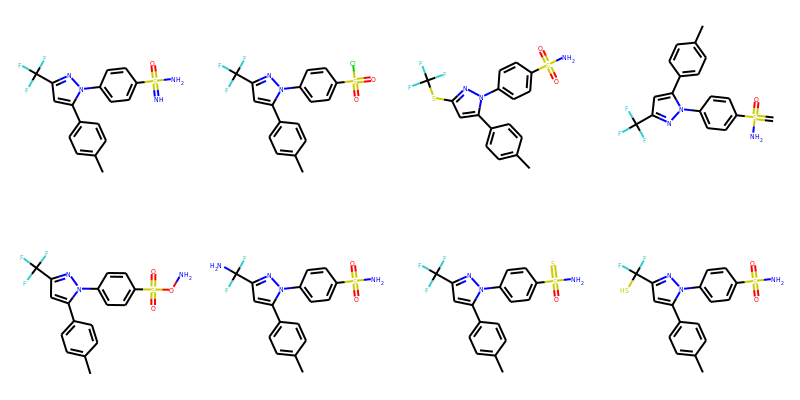

In [78]:
img=Draw.MolsToGridImage(mols_8[:8],molsPerRow=4,subImgSize=(200,200))    
img

### Visualizing Molecules with Similarity > 0.6 & Less than 0.8

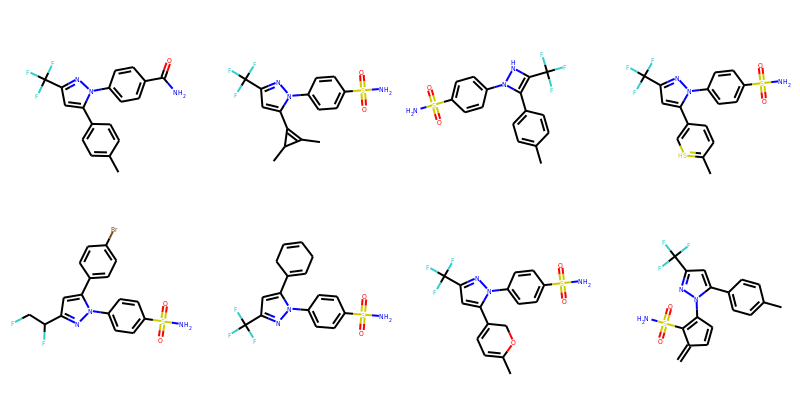

In [79]:
img=Draw.MolsToGridImage(mols_6[:8],molsPerRow=4,subImgSize=(200,200))    
img

### Visualizing Molecules with Similarity > 0.4 Less than 0.6

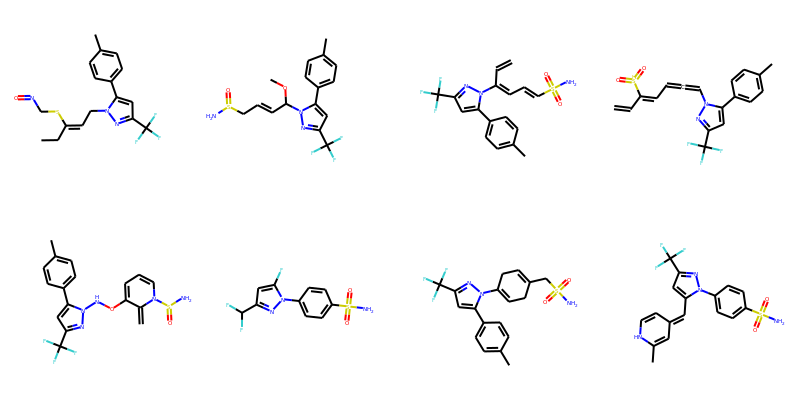

In [80]:
img=Draw.MolsToGridImage(mols_4[:8],molsPerRow=4,subImgSize=(200,200))    
img

### 2. Generating the chemical subspace of Celecoxib while filtering out un-synthetic structures.

For this example, we make use of SYBA to filter out the most synthetic structures: 
1. Code: https://github.com/lich-uct/syba
2. Paper: https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00439-2



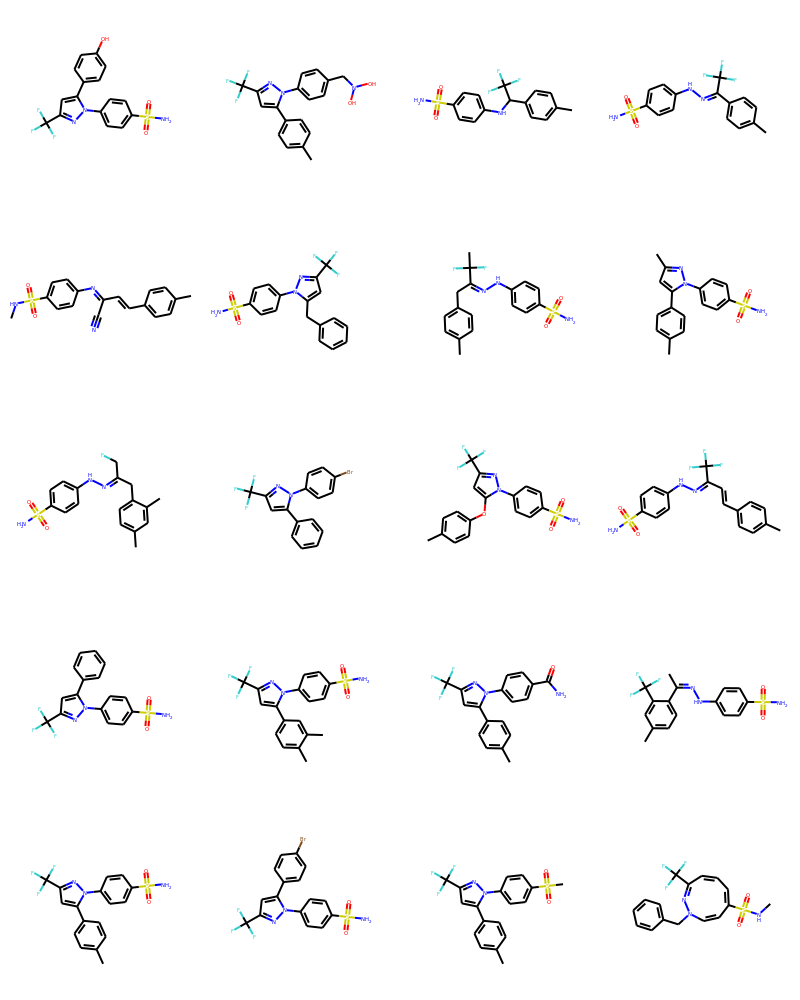

In [82]:
from syba.syba import SybaClassifier
syba = SybaClassifier()
syba.fitDefaultScore()

syba_scores = []
for item in canon_smi_ls: 
    syba_scores.append(syba.predict(smi=item))
        
A = np.argsort(syba_scores)
smi_arranged = [canon_smi_ls[i] for i in A]
smi_arranged = smi_arranged[-20:]

mols_ = [Chem.MolFromSmiles(x) for x in smi_arranged]

img=Draw.MolsToGridImage(mols_,molsPerRow=4,subImgSize=(200,200))    
img

### 3. Generating the chemical subspace of Celecoxib while preserving a specific substructure

We will preserve the structure marked in red for Celecoxib: 

<img src="https://github.com/aspuru-guzik-group/stoned-selfies/blob/main/data/struct_pres.png?raw=True" width="250" />

We write a function with RDKit that can detect the highlighted structure ( substructure_preserver ). While performing mutations with SELFIES, we check if the function returns True (has the substructure). Else, the algorithm is asked to retry/perform a different mutation. Have a look at the specific line: 
```
if len(selfie_mutated_chars) > max_molecules_len or smiles_canon=="" or substructure_preserver(mol)==False:
```

In [83]:
def substructure_preserver(mol):
    """
    Check for substructure violates
    Return True: contains a substructure violation
    Return False: No substructure violation
    """        
    
    if mol.HasSubstructMatch(rdkit.Chem.MolFromSmarts('NS(=O)(=O)c1ccc(-n2cccn2)cc1')) == True:
        return True # The has substructure! 
    else: 
        return False # Molecule does not have substructure!

def mutate_selfie(selfie, max_molecules_len, write_fail_cases=False):
    '''Return a mutated selfie string (only one mutation on slefie is performed)
    
    Mutations are done until a valid molecule is obtained 
    Rules of mutation: With a 33.3% propbabily, either: 
        1. Add a random SELFIE character in the string
        2. Replace a random SELFIE character with another
        3. Delete a random character
    
    Parameters:
    selfie            (string)  : SELFIE string to be mutated 
    max_molecules_len (int)     : Mutations of SELFIE string are allowed up to this length
    write_fail_cases  (bool)    : If true, failed mutations are recorded in "selfie_failure_cases.txt"
    
    Returns:
    selfie_mutated    (string)  : Mutated SELFIE string
    smiles_canon      (string)  : canonical smile of mutated SELFIE string
    '''
    valid=False
    fail_counter = 0
    chars_selfie = get_selfie_chars(selfie)
    
    while not valid:
        fail_counter += 1
                
        alphabet = list(selfies.get_semantic_robust_alphabet()) # 34 SELFIE characters 

        choice_ls = [1, 2, 3] # 1=Insert; 2=Replace; 3=Delete
        random_choice = np.random.choice(choice_ls, 1)[0]
        
        # Insert a character in a Random Location
        if random_choice == 1: 
            random_index = np.random.randint(len(chars_selfie)+1)
            random_character = np.random.choice(alphabet, size=1)[0]
            
            selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index:]

        # Replace a random character 
        elif random_choice == 2:                         
            random_index = np.random.randint(len(chars_selfie))
            random_character = np.random.choice(alphabet, size=1)[0]
            if random_index == 0:
                selfie_mutated_chars = [random_character] + chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index+1:]
                
        # Delete a random character
        elif random_choice == 3: 
            random_index = np.random.randint(len(chars_selfie))
            if random_index == 0:
                selfie_mutated_chars = chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + chars_selfie[random_index+1:]
                
        else: 
            raise Exception('Invalid Operation trying to be performed')

        selfie_mutated = "".join(x for x in selfie_mutated_chars)
        sf = "".join(x for x in chars_selfie)
        
        try:
            smiles = decoder(selfie_mutated)
            mol, smiles_canon, done = sanitize_smiles(smiles)
            if len(selfie_mutated_chars) > max_molecules_len or smiles_canon=="" or substructure_preserver(mol)==False:
                done = False
            if done:
                valid = True
            else:
                valid = False
        except:
            valid=False
            if fail_counter > 1 and write_fail_cases == True:
                f = open("selfie_failure_cases.txt", "a+")
                f.write('Tried to mutate SELFIE: '+str(sf)+' To Obtain: '+str(selfie_mutated) + '\n')
                f.close()
    
    return (selfie_mutated, smiles_canon)

In [84]:
smi     = 'CC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)N)C(F)(F)F'   # Celecoxib
fp_type = 'ECFP4'


total_time = time.time()
# num_random_samples = 50000 # For a more exhaustive search! 
num_random_samples = 100     
num_mutation_ls    = [1, 2, 3, 4, 5]

mol = Chem.MolFromSmiles(smi)
if mol == None: 
    raise Exception('Invalid starting structure encountered')

start_time = time.time()
randomized_smile_orderings  = [randomize_smiles(mol) for _ in range(num_random_samples)]

# Convert all the molecules to SELFIES
selfies_ls = [encoder(x) for x in randomized_smile_orderings]
print('Randomized molecules (in SELFIES) time: ', time.time()-start_time)


all_smiles_collect = []
all_smiles_collect_broken = []

start_time = time.time()
for num_mutations in num_mutation_ls: 
    # Mutate the SELFIES: 
    selfies_mut = get_mutated_SELFIES(selfies_ls.copy(), num_mutations=num_mutations)

    # Convert back to SMILES: 
    smiles_back = [decoder(x) for x in selfies_mut]
    all_smiles_collect = all_smiles_collect + smiles_back
    all_smiles_collect_broken.append(smiles_back)


print('Mutation obtainment time (back to smiles): ', time.time()-start_time)


# Work on:  all_smiles_collect
start_time = time.time()
canon_smi_ls = []
for item in all_smiles_collect: 
    mol, smi_canon, did_convert = sanitize_smiles(item)
    if mol == None or smi_canon == '' or did_convert == False: 
        raise Exception('Invalid smile string found')
    canon_smi_ls.append(smi_canon)
canon_smi_ls        = list(set(canon_smi_ls))
print('Unique mutated structure obtainment time: ', time.time()-start_time)

start_time = time.time()
canon_smi_ls_scores = get_fp_scores(canon_smi_ls, target_smi=smi, fp_type=fp_type)
print('Fingerprint calculation time: ', time.time()-start_time)
print('Total time: ', time.time()-total_time)

# Molecules with fingerprint similarity > 0.8
indices_thresh_8 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.8]
mols_8 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_8]

# Molecules with fingerprint similarity > 0.6
indices_thresh_6 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.6 and x < 0.8]
mols_6 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_6]

# Molecules with fingerprint similarity > 0.4
indices_thresh_4 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.4 and x < 0.6]
mols_4 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_4]

Randomized molecules (in SELFIES) time:  0.010976314544677734
Mutation obtainment time (back to smiles):  3.784165382385254
Unique mutated structure obtainment time:  0.11872649192810059
Fingerprint calculation time:  0.09495353698730469
Total time:  4.010370254516602


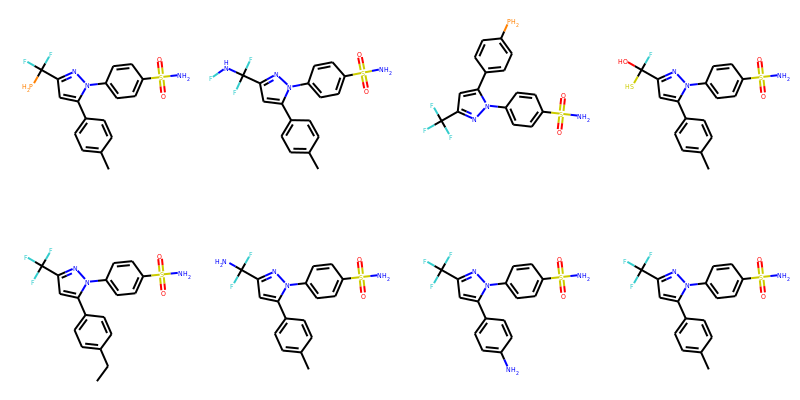

In [85]:
img=Draw.MolsToGridImage(mols_8[:8],molsPerRow=4,subImgSize=(200,200))    
img

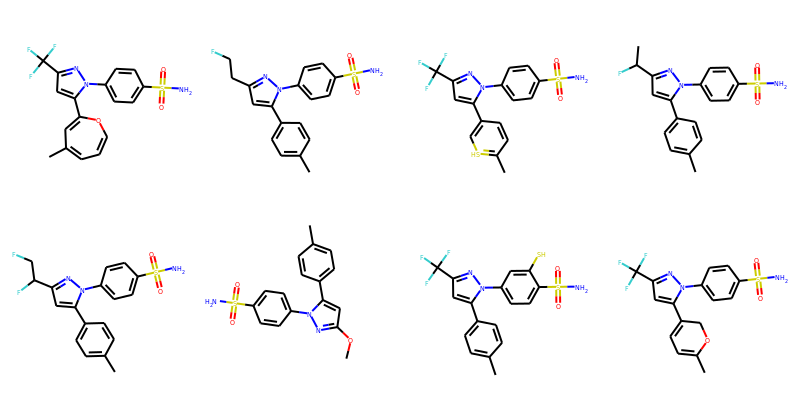

In [86]:
img=Draw.MolsToGridImage(mols_6[:8],molsPerRow=4,subImgSize=(200,200))    
img

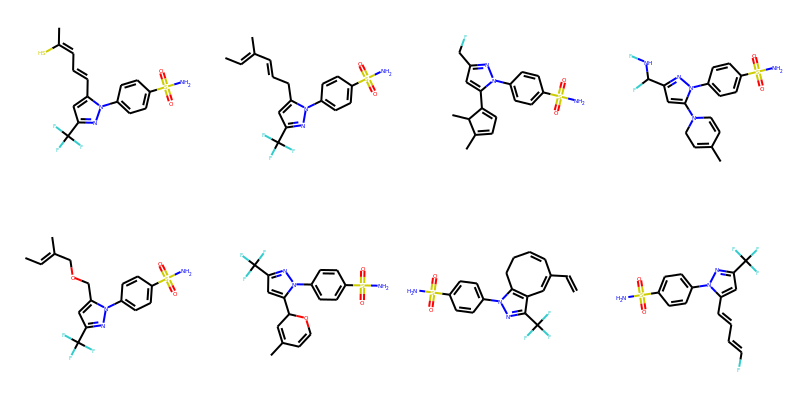

In [87]:
img=Draw.MolsToGridImage(mols_4[:8],molsPerRow=4,subImgSize=(200,200))    
img


# Chemical Path Formation: 
## Imports for Chemical Path Formation

In [93]:
import os
import numpy as np 
import random
from random import randrange
import matplotlib.pyplot as plt
import rdkit
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import MolToSmiles as mol2smi
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from selfies import encoder, decoder 


import seaborn as sns
import selfies
import random
import numpy as np
from selfies import encoder, decoder

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

def get_ECFP4(mol):
    ''' Return rdkit ECFP4 fingerprint object for mol

    Parameters: 
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object  

    Returns: 
    rdkit ECFP4 fingerprint object for mol
    '''
    return AllChem.GetMorganFingerprint(mol, 2)

def sanitize_smiles(smi):
    '''Return a canonical smile representation of smi
    
    Parameters:
    smi (string) : smile string to be canonicalized 
    
    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object                          (None if invalid smile string smi)
    smi_canon (string)          : Canonicalized smile representation of smi (None if invalid smile string smi)
    conversion_successful (bool): True/False to indicate if conversion was  successful 
    '''
    try:
        mol = smi2mol(smi, sanitize=True)
        smi_canon = mol2smi(mol, isomericSmiles=False, canonical=True)
        return (mol, smi_canon, True)
    except:
        return (None, None, False)

def get_fp_scores(smiles_back, target_smi): 
    '''Calculate the Tanimoto fingerprint (ECFP4 fingerint) similarity between a list 
       of SMILES and a known target structure (target_smi). 
       
    Parameters:
    smiles_back   (list) : A list of valid SMILES strings 
    target_smi (string)  : A valid SMILES string. Each smile in 'smiles_back' will be compared to this stucture
    
    Returns: 
    smiles_back_scores (list of floats) : List of fingerprint similarities
    '''
    smiles_back_scores = []
    target    = Chem.MolFromSmiles(target_smi)
    fp_target = get_ECFP4(target)
    for item in smiles_back: 
        mol    = Chem.MolFromSmiles(item)
        fp_mol = get_ECFP4(mol)
        score  = TanimotoSimilarity(fp_mol, fp_target)
        smiles_back_scores.append(score)
    return smiles_back_scores


def get_selfie_chars(selfie):
    '''Obtain a list of all selfie characters in string selfie
    
    Parameters: 
    selfie (string) : A selfie string - representing a molecule 
    
    Example: 
    >>> get_selfie_chars('[C][=C][C][=C][C][=C][Ring1][Branch1_1]')
    ['[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[Branch1_1]']
    
    Returns:
    chars_selfie: list of selfie characters present in molecule selfie
    '''
    chars_selfie = [] # A list of all SELFIE sybols from string selfie
    while selfie != '':
        chars_selfie.append(selfie[selfie.find('['): selfie.find(']')+1])
        selfie = selfie[selfie.find(']')+1:]
    return chars_selfie


def randomize_smiles(mol):
    '''Returns a random (dearomatized) SMILES given an rdkit mol object of a molecule.

    Parameters:
    mol (rdkit.Chem.rdchem.Mol) :  RdKit mol object (None if invalid smile string smi)
    
    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object  (None if invalid smile string smi)
    '''
    if not mol:
        return None

    Chem.Kekulize(mol)
    
    return rdkit.Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=False,  kekuleSmiles=True)


def get_random_smiles(smi, num_random_samples): 
    ''' Obtain 'num_random_samples' non-unique SMILES orderings of smi
    
    Parameters:
    smi (string)            : Input SMILES string (needs to be a valid molecule)
    num_random_samples (int): Number fo unique different SMILES orderings to form 
    
    Returns:
    randomized_smile_orderings (list) : list of SMILES strings
    '''
    mol = Chem.MolFromSmiles(smi)
    if mol == None: 
        raise Exception('Invalid starting structure encountered')
    randomized_smile_orderings  = [randomize_smiles(mol) for _ in range(num_random_samples)]
    randomized_smile_orderings  = list(set(randomized_smile_orderings)) # Only consider unique SMILE strings
    return randomized_smile_orderings


def obtain_path(starting_smile, target_smile, filter_path=False): 
    ''' Obtain a path/chemical path from starting_smile to target_smile
    
    Parameters:
    starting_smile (string) : SMILES string (needs to be a valid molecule)
    target_smile (int)      : SMILES string (needs to be a valid molecule)
    filter_path (bool)      : If True, a chemical path is returned, else only a path
    
    Returns:
    path_smiles (list)                  : A list of smiles in path between starting_smile & target_smile
    path_fp_scores (list of floats)     : Fingerprint similarity to 'target_smile' for each smiles in path_smiles
    smiles_path (list)                  : A list of smiles in CHEMICAL path between starting_smile & target_smile (if filter_path==False, then empty)
    filtered_path_score (list of floats): Fingerprint similarity to 'target_smile' for each smiles in smiles_path (if filter_path==False, then empty)
    '''
    starting_selfie = encoder(starting_smile)
    target_selfie   = encoder(target_smile)
    
    starting_selfie_chars = get_selfie_chars(starting_selfie)
    target_selfie_chars   = get_selfie_chars(target_selfie)
    
    # Pad the smaller string
    if len(starting_selfie_chars) < len(target_selfie_chars): 
        for _ in range(len(target_selfie_chars)-len(starting_selfie_chars)):
            starting_selfie_chars.append(' ')
    else: 
        for _ in range(len(starting_selfie_chars)-len(target_selfie_chars)):
            target_selfie_chars.append(' ')
    
    indices_diff = [i for i in range(len(starting_selfie_chars)) if starting_selfie_chars[i] != target_selfie_chars[i]]
    path         = {}
    path[0]  = starting_selfie_chars
    
    for iter_ in range(len(indices_diff)): 
        idx = np.random.choice(indices_diff, 1)[0] # Index to be operated on
        indices_diff.remove(idx)                   # Remove that index
        
        # Select the last member of path: 
        path_member = path[iter_].copy()
        
        # Mutate that character to the correct value: 
        path_member[idx] = target_selfie_chars[idx]
        path[iter_+1] = path_member.copy()
    
    # Collapse path to make them into SELFIE strings
    paths_selfies = []
    for i in range(len(path)):
        selfie_str = ''.join(x for x in path[i])
        paths_selfies.append(selfie_str.replace(' ', ''))
        
    if paths_selfies[-1] != target_selfie: 
        raise Exception("Unable to discover target structure!")
    
    # Obtain similarity scores, and only choose the increasing members: 
    path_smiles         = [decoder(x) for x in paths_selfies]
    path_fp_scores      = []
    filtered_path_score = []
    smiles_path         = []
    
    if filter_path: 
        path_fp_scores = get_fp_scores(path_smiles, target_smile)
        
        filtered_path_score = []
        smiles_path   = []
        for i in range(1, len(path_fp_scores)-1): 
            if i == 1: 
                filtered_path_score.append(path_fp_scores[1])
                smiles_path.append(path_smiles[i])
                continue
            if filtered_path_score[-1] < path_fp_scores[i]:
                filtered_path_score.append(path_fp_scores[i])
                smiles_path.append(path_smiles[i])

    return path_smiles, path_fp_scores, smiles_path, filtered_path_score


def get_compr_paths(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional):
    ''' Obtaining multiple paths/chemical paths from starting_smile to target_smile. 
    
    Parameters:
    starting_smile (string)     : SMILES string (needs to be a valid molecule)
    target_smile (int)          : SMILES string (needs to be a valid molecule)
    num_tries (int)             : Number of path/chemical path attempts between the exact same smiles
    num_random_samples (int)    : Number of different SMILES string orderings to conside for starting_smile & target_smile 
    collect_bidirectional (bool): If true, forms paths from target_smiles-> target_smiles (doubles number of paths)
    
    Returns:
    smiles_paths_dir1 (list): list paths containing smiles in path between starting_smile -> target_smile
    smiles_paths_dir2 (list): list paths containing smiles in path between target_smile -> starting_smile
    '''
    starting_smile_rand_ord = get_random_smiles(starting_smile, num_random_samples=num_random_samples)
    target_smile_rand_ord   = get_random_smiles(target_smile,   num_random_samples=num_random_samples)
    
    smiles_paths_dir1 = [] # All paths from starting_smile -> target_smile
    for smi_start in starting_smile_rand_ord: 
        for smi_target in target_smile_rand_ord: 
            
            if Chem.MolFromSmiles(smi_start) == None or Chem.MolFromSmiles(smi_target) == None: 
                raise Exception('Invalid structures')
                
            for _ in range(num_tries): 
                path, _, _, _ = obtain_path(smi_start, smi_target, filter_path=True)
                smiles_paths_dir1.append(path)
    
    smiles_paths_dir2 = [] # All paths from starting_smile -> target_smile
    if collect_bidirectional == True: 
        starting_smile_rand_ord = get_random_smiles(target_smile, num_random_samples=num_random_samples)
        target_smile_rand_ord   = get_random_smiles(starting_smile,   num_random_samples=num_random_samples)
        
        for smi_start in starting_smile_rand_ord: 
            for smi_target in target_smile_rand_ord: 
                
                if Chem.MolFromSmiles(smi_start) == None or Chem.MolFromSmiles(smi_target) == None: 
                    raise Exception('Invalid structures')
        
                for _ in range(num_tries): 
                    path, _, _, _ = obtain_path(smi_start, smi_target, filter_path=True)
                    smiles_paths_dir2.append(path)
                    
    return smiles_paths_dir1, smiles_paths_dir2




## Analyzing QED & LogP values for a Chemical Path between Tadalafil & Sildenafil: 
The get_compr_paths() function generates multiple chemical paths between two input SMILES. 

Starting logP:2.2113000000000005 QED:0.6925587527204076
Target logP:1.6109 QED:0.5534046105187581
Initiating path collection
Path collection complete
Min -0.42633599999999994 Max 0.2702995311671156


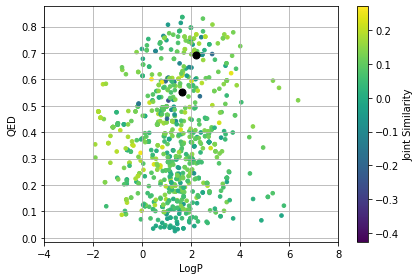

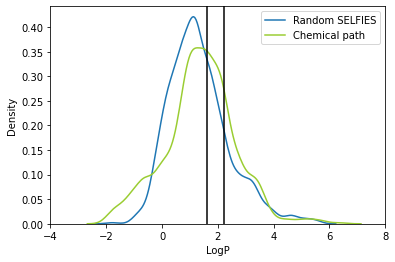

/home/akshat/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/akshat/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


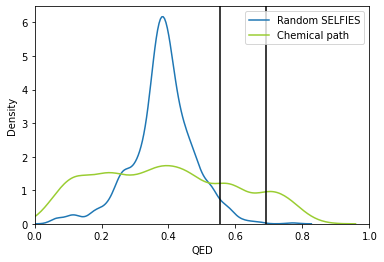

In [94]:
def get_ECFP4(mol):
    return AllChem.GetMorganFingerprint(mol, 2)

def get_fp_scores(smiles_back, target_smi): 
    smiles_back_scores = []
    target    = Chem.MolFromSmiles(target_smi)
    fp_target = get_ECFP4(target)
    for item in smiles_back: 
        mol    = Chem.MolFromSmiles(item)
        fp_mol = get_ECFP4(mol)
        score  = TanimotoSimilarity(fp_mol, fp_target)
        smiles_back_scores.append(score)
    return smiles_back_scores


def get_logP(mol):
    '''Calculate logP of a molecule 
    
    Parameters:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object, for which logP is to calculates
    
    Returns:
    float : logP of molecule (mol)
    '''
    return Descriptors.MolLogP(mol)

def get_selfie_chars(selfie):
    '''Obtain a list of all selfie characters in string selfie
    
    Parameters: 
    selfie (string) : A selfie string - representing a molecule 
    
    Example: 
    >>> get_selfie_chars('[C][=C][C][=C][C][=C][Ring1][Branch1_1]')
    ['[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[Branch1_1]']
    
    Returns:
    chars_selfie: list of selfie characters present in molecule selfie
    '''
    chars_selfie = [] # A list of all SELFIE sybols from string selfie
    while selfie != '':
        chars_selfie.append(selfie[selfie.find('['): selfie.find(']')+1])
        selfie = selfie[selfie.find(']')+1:]
    return chars_selfie




starting_smile = 'CN1CC(=O)N2C(C1=O)CC3=C(C2C4=CC5=C(C=C4)OCO5)NC6=CC=CC=C36'       # Tadalafil
target_smile   = 'CCCC1=NN(C2=C1N=C(NC2=O)C3=C(C=CC(=C3)S(=O)(=O)N4CCN(CC4)C)OCC)C' # Sildenafil 

mol_starting = Chem.MolFromSmiles(starting_smile)
mol_target   = Chem.MolFromSmiles(target_smile)

qed_starting = Chem.QED.qed(mol_starting)
qed_target   = Chem.QED.qed(mol_target)

logP_starting = get_logP(mol_starting)
logP_target   = get_logP(mol_target)


scores_start_1  = get_fp_scores([starting_smile], starting_smile)   # similarity to target
scores_target_1 = get_fp_scores([starting_smile], target_smile)     # similarity to starting structure
data          = np.array([scores_target_1, scores_start_1])
avg_score_1     = np.average(data, axis=0)
better_score_1  = avg_score_1 - (np.abs(data[0] - data[1])) 
better_score_1 = ((1/9) * better_score_1**3) - ((7/9) * better_score_1**2) + ((19/12) * better_score_1)


scores_start_2  = get_fp_scores([target_smile], starting_smile)   # similarity to target
scores_target_2 = get_fp_scores([target_smile], target_smile)     # similarity to starting structure
data          = np.array([scores_target_2, scores_start_2])
avg_score_2     = np.average(data, axis=0)
better_score_2  = avg_score_2 - (np.abs(data[0] - data[1])) 
better_score_2 = ((1/9) * better_score_2**3) - ((7/9) * better_score_2**2) + ((19/12) * better_score_2)


print('Starting logP:{} QED:{}'.format(logP_starting, qed_starting))
print('Target logP:{} QED:{}'.format(logP_target, qed_target))

   
num_tries             = 2 
num_random_samples    = 2 
collect_bidirectional = True # Doubles the number of paths: source->target & target->source

print('Initiating path collection')
smiles_paths_dir1, smiles_paths_dir2 = get_compr_paths(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional)
print('Path collection complete')


# Find the median molecule & plot: 
all_smiles_dir_1 = [item for sublist in smiles_paths_dir1 for item in sublist] # all the smile string of dir1
all_smiles_dir_2 = [item for sublist in smiles_paths_dir2 for item in sublist] # all the smile string of dir2

all_smiles = all_smiles_dir_1 + all_smiles_dir_2
logP_path  = [get_logP(Chem.MolFromSmiles(x)) for x in all_smiles]
QED_path   = [Chem.QED.qed(Chem.MolFromSmiles(x)) for x in all_smiles]
    
scores_start  = get_fp_scores(all_smiles, starting_smile)   # similarity to target
scores_target = get_fp_scores(all_smiles, target_smile)     # similarity to starting structure
data          = np.array([scores_target, scores_start])
avg_score     = np.average(data, axis=0)
better_score  = avg_score - (np.abs(data[0] - data[1]))   
better_score = ((1/9) * better_score**3) - ((7/9) * better_score**2) + ((19/12) * better_score)




# Filter based on better score: 
apply_score_threshold = False 
if apply_score_threshold: 
    indices_threshold = []
    for i in range(len(better_score)): 
        if better_score[i] >= -20: # 0.2 = if required, Threshold! 
            indices_threshold.append(i)
            
    all_smiles = [all_smiles[i] for i in indices_threshold]
    logP_path  = [get_logP(Chem.MolFromSmiles(x)) for x in all_smiles]
    QED_path   = [Chem.QED.qed(Chem.MolFromSmiles(x)) for x in all_smiles]

    scores_start  = get_fp_scores(all_smiles, starting_smile)   # similarity to target
    scores_target = get_fp_scores(all_smiles, target_smile)     # similarity to starting structure
    data          = np.array([scores_target, scores_start])
    avg_score     = np.average(data, axis=0)
    better_score  = avg_score - (np.abs(data[0] - data[1]))   
    better_score = ((1/9) * better_score**3) - ((7/9) * better_score**2) + ((19/12) * better_score)



print('Min {} Max {}'.format(min(better_score), max(better_score)))
# raise Exception('get vmax value')

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cm = plt.cm.get_cmap('viridis')
sc = ax.scatter(logP_path, QED_path, c=better_score.tolist(), cmap=cm, s=13) 
clb = plt.colorbar(sc)

sc = ax.plot([logP_starting, logP_target], [qed_starting, qed_target], 'o', c='black', markersize=7, linewidth=3) # TARGETS 

clb.set_label('Joint Similarity', fontsize=10)
ax.set_xlabel('LogP', fontsize=10)
ax.set_ylabel('QED', fontsize=10)
plt.xlim([-4, 8])

ax.grid(True)
fig.tight_layout()

plt.show()

alphabet = list(selfies.get_semantic_robust_alphabet()) # 34 SELFIE characters 
max_len_random_struct = max([len(get_selfie_chars(encoder(starting_smile))), len(get_selfie_chars(encoder(target_smile)))])
min_len_random_struct = min([len(get_selfie_chars(encoder(starting_smile))), len(get_selfie_chars(encoder(target_smile)))])
num_samples = len(logP_path)
random_selfies = []

for _ in range(num_samples): 
    selfie = ''

    for i in range(random.randint(min_len_random_struct, max_len_random_struct)): # max_molecules_len = max random selfie string length 
        selfie = selfie + np.random.choice(alphabet, size=1)[0]
    random_selfies.append(selfie)
    
random_smiles = [decoder(x) for x in random_selfies]
scores_start_rnd  = get_fp_scores(random_smiles, starting_smile)   # similarity to target
scores_target_rnd = get_fp_scores(random_smiles, target_smile)     # similarity to starting structure
data_rnd          = np.array([scores_target_rnd, scores_start_rnd])
avg_score_rnd     = np.average(data_rnd, axis=0)
better_score_random  = avg_score_rnd - (np.abs(data_rnd[0] - data_rnd[1]))   

better_score_random = ((1/9) * better_score_random**3) - ((7/9) * better_score_random**2) + ((19/12) * better_score_random)

logP_path_random  = [get_logP(Chem.MolFromSmiles(x)) for x in random_smiles]
QED_path_random   = [Chem.QED.qed(Chem.MolFromSmiles(x)) for x in random_smiles]

# DISTRIBUTION PLOTS! 
A = sns.kdeplot(logP_path_random, bw_method=0.2, label="Random SELFIES")
A = sns.kdeplot(logP_path, bw_method=0.2, label="Chemical path", color='yellowgreen')

plt.axvline(logP_starting, 0, 1.0, c='black') # vertical line
plt.axvline(logP_target, 0, 1.0, c='black') # vertical line


A.set_xlabel('LogP', fontsize=10)
A.set_ylabel('Density', fontsize=10)
plt.xlim([-4, 8])
plt.legend()
# plt.savefig('./final_saved/logP_distrb.svg', dpi=500)
plt.show()


B = sns.kdeplot(QED_path_random, bw=.2, label="Random SELFIES")
B = sns.kdeplot(QED_path, bw=.2, label="Chemical path", color='yellowgreen')
plt.axvline(qed_starting, 0, 1.0, c='black') # vertical line
plt.axvline(qed_target, 0, 1.0, c='black') # vertical line
B.set_xlabel('QED', fontsize=10)
B.set_ylabel('Density', fontsize=10)
plt.xlim([0, 1])
plt.legend()
plt.show()

# Median Molecule Formation: 


TODO